In [8]:
import matplotlib
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from scipy import linalg, matrix
from scipy.interpolate import  griddata

#Exercise 2

---



Some function used for DLT algorithm (Professor Pirri's github code)

In [9]:
def load_image(im):  
    try:
        imx = Image.open(im)
        return np.array(imx)
        # else
    except IOError:
        return []
  
def generate_GT(xx):
    plt.figure(2)
    zzd = np.zeros((5,3))   
    for ii in range(len(xx)-1):         
#        x2 =xx[ii+1][0]; y2=xx[ii+1][1]
        x1 =xx[ii][0]; y1=xx[ii][1]
        zzd[ii,0] = x1; zzd[ii,1] = y1; zzd[ii,2] = 1; 
        plt.plot([xx[ii][0],xx[ii+1][0]], [xx[ii][1],xx[ii+1][1]], 'ro-') 
    jj = 0
    aa = [0,0,1,0,1,3,0,3]
    zz = np.zeros((5,3))     
    for ii in range(len(zzd)-1):
            zz[ii,0] = zzd[aa[jj],0] 
            zz[ii,1] = zzd[aa[jj+1],1] 
            zz[ii,2] = 1;
            jj = jj+2
    zz[4,:] = zz[0,:]
    for ii in range(4):      
        plt.plot([zz[ii,0],zz[ii+1,0]], [zz[ii,1],zz[ii+1,1]], 'go-')
    plt.show()
    return zz[0:4,:],zzd[0:4,:]    
        
    
#We have x' = z and x =zd
def normalize_points(zz):
    uu = zz.T
    ff_xx = np.ones(uu.shape)
    indices, = np.where(abs(uu[2,:]) > 10**-12)
    ff_xx[0:2,indices] = uu[0:2,indices]/uu[2,indices]
    ff_xx[2,indices]  = 1.
    mu = np.mean(ff_xx[0:2,:],axis = 1)
    mu_r = np.zeros((mu.shape[0],ff_xx.shape[1]))
    for ii in range(ff_xx.shape[1]):
        mu_r[:,ii] = mu
    mu_dist = np.mean((np.sum((ff_xx[0:2] - mu_r)**2,axis =0))**0.5)
    scale =  (2**0.5/mu_dist)
    s0 = -scale*mu[0]
    s1 = -scale*mu[1]
    S = np.array([[scale, 0, s0],[0, scale, s1], [0, 0, 1]])
    normalized_zz = S@ff_xx
    return normalized_zz, S

### Transform Image

def image_rebound(mm,nn,hh):
    W = np.array([[1, nn, nn, 1 ],[1, 1, mm, mm],[ 1, 1, 1, 1]])
    ws = np.dot(hh,W)
    ### scaling
    xx = np.vstack((ws[2,:],ws[2,:],ws[2,:]))
    wsX =  np.round(ws/xx)
    bounds = [np.min(wsX[1,:]), np.max(wsX[1,:]),np.min(wsX[0,:]), np.max(wsX[0,:])]
    return bounds


def make_transform(imm,hh):   
    mm,nn = imm.shape[0],imm.shape[0]
    bounds = image_rebound(mm,nn,hh)
    nrows = bounds[1] - bounds[0]
    ncols = bounds[3] - bounds[2]
    s = max(nn,mm)/max(nrows,ncols)
    scale = np.array([[s, 0, 0],[0, s, 0], [0, 0, 1]])
    trasf = scale@hh
    trasf_prec =  np.linalg.inv(trasf)
    bounds = image_rebound(mm,nn,trasf)
    nrows = (bounds[1] - bounds[0]).astype(np.int)
    ncols = (bounds[3] - bounds[2]).astype(np.int)
    return bounds, nrows, ncols, trasf, trasf_prec


def get_new_image(nrows,ncols,imm,bounds,trasf_prec,nsamples):
    xx  = np.linspace(1, ncols, ncols)
    yy  = np.linspace(1, nrows, nrows)
    [xi,yi] = np.meshgrid(xx,yy) 
    a0 = np.reshape(xi, -1,order ='F')+bounds[2]
    a1 = np.reshape(yi,-1, order ='F')+bounds[0]
    a2 = np.ones((ncols*nrows))
    uv = np.vstack((a0.T,a1.T,a2.T)) 
    new_trasf = np.dot(trasf_prec,uv)
    val_normalization = np.vstack((new_trasf[2,:],new_trasf[2,:],new_trasf[2,:]))
   
    ### The new transformation
    newT = new_trasf/val_normalization
    
    ### 
    xi = np.reshape(newT[0,:],(nrows,ncols),order ='F') 
    yi = np.reshape(newT[1,:],(nrows,ncols),order ='F')
    cols = imm.shape[1]
    rows = imm.shape[0]
    xxq  = np.linspace(1, rows, rows).astype(np.int)
    yyq  = np.linspace(1, cols, cols).astype(np.int)
    [x,y] = np.meshgrid(yyq,xxq) 
    x = (x - 1).astype(np.int) #Offset x and y relative to region origin.
    y = (y - 1).astype(np.int) 
        
    ix = np.random.randint(imm.shape[1], size=nsamples)
    iy = np.random.randint(imm.shape[0], size=nsamples)
    samples = imm[iy,ix]
       
    int_im = griddata((iy,ix), samples, (yi,xi))
    
    #Plotting
    fig = plt.figure(figsize=(8*3, 8*3))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(imm)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(int_im.astype(np.uint8))
    plt.show()

##**Upload to this colab the image "Chess_img.png" found in the zipped file I sent.**

In [10]:
path = "./Chess_img.png"
img =  load_image(path)

Four points were chosen by hand by searching in the image in order to obtain a tile. In the plot I have highlighted what will be the segments

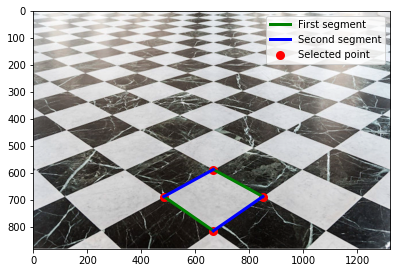

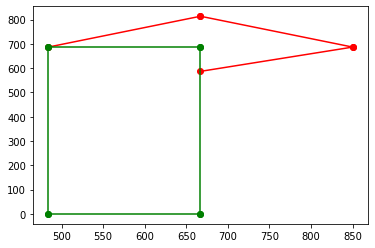

In [11]:
# The four points chosen
xx = [(484,687), (667,814), (850,687), (667,587)]

plt.figure(figsize=(6.4*1, 4.8*1))

plt.imshow(img), 
plt.scatter([xx[0][0], xx[1][0], xx[2][0], xx[3][0]], [xx[0][1], xx[1][1], xx[2][1], xx[3][1]], color = 'r', linewidth = 3, label = "Selected point"),
plt.plot([xx[0][0], xx[1][0]], [xx[0][1], xx[1][1]], color = 'g', linewidth = 3, label = "First segment")
plt.plot([xx[2][0], xx[3][0]], [xx[2][1], xx[3][1]], color = 'g', linewidth = 3)
plt.plot([xx[0][0], xx[3][0]], [xx[0][1], xx[3][1]], color = 'b', linewidth = 3, label = "Second segment")
plt.plot([xx[1][0], xx[2][0]], [xx[1][1], xx[2][1]], color = 'b', linewidth = 3)

plt.legend()

zz, zzd = generate_GT(xx)

Given the *points* $x_1$, $x_2$, $x_3$, $x_4$ (with *third co-ordinate = 1*) I created the lines $l_1$, $l_2$, $l_3$ and $l_4$ of the tile as a **cross product between the points of the segment**. Afterwards the lines were **normalized** by dividing by the third parameter.

I calculated the *vanishing point* of the two **parallel** lines $l_i$ and $l_j$ as their cross product. This is because their cross product should give me the **intersection** of the two lines which is precisely the vanishing point. This calculation was applied for the two pairs of lines obtaining the two vanishing points $v_1$ and $v_2$. The vanishing points were **normalized** by dividing by the third parameter.

Then the *vanishing line* $l$ was calculated as a line given the two points, i.e., as a cross product of the two vanishing points.

At the end a *plot* was made to show: 
1.   **The points** used to construct the lines; 
2.   **The vanishing points** and how they actually line up with the chosen tile;
3.   **The vanishing line**.

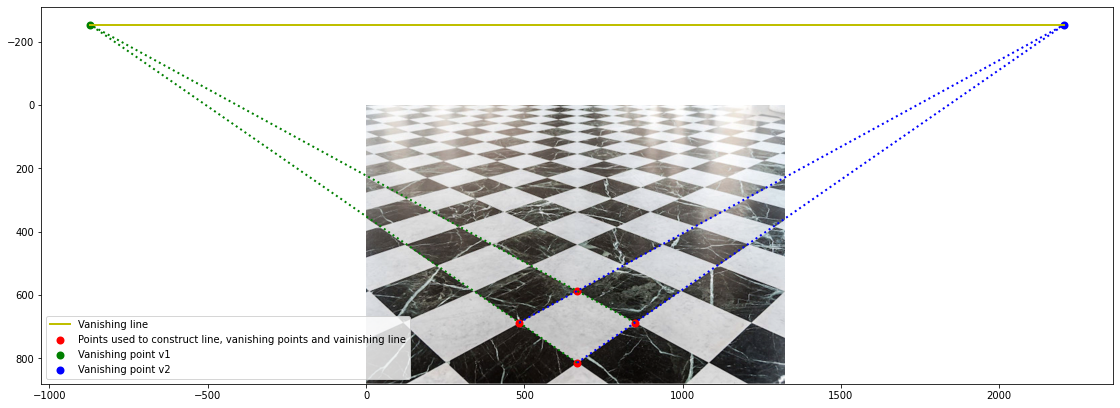

In [12]:
# The four points of the chosen tile with 1 as third parameter
x1 = np.array([xx[0][0], xx[0][1], 1])
x2 = np.array([xx[1][0], xx[1][1], 1])
x3 = np.array([xx[2][0], xx[2][1], 1])
x4 = np.array([xx[3][0], xx[3][1], 1])

# The lines corresponding to the segments as a cross product between the 2 points forming it
# The two parallel segment pointing to the left
l1 = np.cross(x3,x4)
l2 = np.cross(x2,x1)
# The two parallel segment pointing to the right
l3 = np.cross(x1,x4)
l4 = np.cross(x2,x3)
# Lines normalization
l1 = l1/l1[2]
l2 = l2/l2[2]
l3 = l3/l3[2]
l4 = l4/l4[2]

# Vanishing point calculated as cross product between the two parallel line. 
# This cross prdouct should be the intersection between the two lines
v1 = np.cross(l1,l2)
v2 = np.cross(l3,l4)
# Vanishing points normalization
v1 = v1/v1[2]
v2 = v2/v2[2]

# Vanishing line calculated as cross product between the two vanishing points. 
# This cross product should construct the line between the two points
l = np.cross(v1,v2)
# Vanishing line normalization
l = l/l[2]

# Plot
plt.figure(figsize=(6.4*3, 4.8*3))
plt.imshow(img)

# Tile's points
plt.scatter([xx[0][0], xx[1][0], xx[2][0], xx[3][0]], [xx[0][1], xx[1][1], xx[2][1], xx[3][1]], color = 'r', linewidth = 2, label = "Points used to construct line, vanishing points and vainishing line")

# Vanishing point v1
plt.scatter([v1[0]], [v1[1]], color = 'g', linewidth = 2, label = "Vanishing point v1")
plt.plot([x2[0], v1[0]], [x2[1], v1[1]], color = 'g', linewidth = 2, linestyle=':')
plt.plot([x3[0], v1[0]], [x3[1], v1[1]], color = 'g', linewidth = 2, linestyle=':')

# Vanishing point v2
plt.scatter([v2[0]], [v2[1]], color = 'b', linewidth = 2, label = "Vanishing point v2")
plt.plot([x2[0], v2[0]], [x2[1], v2[1]], color = 'b', linewidth = 2, linestyle=':')
plt.plot([x1[0], v2[0]], [x1[1], v2[1]], color = 'b', linewidth = 2, linestyle=':')

# Vanishing line
plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color = 'y', linewidth = 2, label = "Vanishing line")

plt.legend()

To solve **point 1** of the exercise, I created the homography $H_P$ as shown, using the vanishing line $l$ found previously.

To solve **point 2**, I created an affine transformation $H_A$, using a rotation with angle $\alpha$ equal to the angle between the first segments of the two vectors computed with *generate_GT()*. 

$R =
 \begin{pmatrix}
  cos(\alpha) & -sin(\alpha) & 0 \\
  sin(\alpha) & cos(\alpha) & 0 \\
  0 & 0 & 1
 \end{pmatrix}$

$H_A = R$

For **point 3**, I created $H$ as a cross product between $H_A$ and $H_P$: 
1.   $H*l^T$ must be the line at infinity $[0,\ 0,\ 1]$; 
2.   The last line of $H$ must be equal to the vanishing line $l$

In [13]:
# Normalize points and return also scaling matrix
norm_points_distorted, T1_norm = normalize_points(zzd)
norm_points_GT, T2_norm= normalize_points(zz)

# Homography
Hp = np.array([[1, 0, 0],
               [0, 1, 0],
               [l[0], l[1], l[2]]])

# Affine transformation
# Calculate alpha as angle between first vector of T1_norm and T2_norm
segA = T1_norm[0]/T1_norm[0][2]
segB = T2_norm[0]/T2_norm[0][2]
alpha = np.arccos(segA @ segB/(np.linalg.norm(segA)*np.linalg.norm(segB)))
# Calculate rotation of alpha degree
R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
               [np.sin(alpha), np.cos(alpha), 0],
               [0, 0, 1]])

# An affine transformation Ha is equal to T*R*Sh*S. I have only R so:
Ha = R

# Calculated H I check if H*l.T is line at infinity and if last row of H is l
H = Ha@Hp

print("A FEW CHECKS BEFORE CONTINUING")
print("H * vanishing_line.T should be the line at infinity [0, 0, 1]:\nH*l.T = ", np.linalg.inv(H).T @ l.T)
print("\nThe last row of H = Ha * Hp should be the vanishing line l:\nH = \n", H, "\nl = \n", l)

A FEW CHECKS BEFORE CONTINUING
H * vanishing_line.T should be the line at infinity [0, 0, 1]:
H*l.T =  [0. 0. 1.]

The last row of H = Ha * Hp should be the vanishing line l:
H = 
 [[ 9.99999966e-01 -2.60381625e-04  0.00000000e+00]
 [ 2.60381625e-04  9.99999966e-01  0.00000000e+00]
 [-2.18407759e-19  3.94103051e-03  1.00000000e+00]] 
l = 
 [-2.18407759e-19  3.94103051e-03  1.00000000e+00]


Compute **DLT algorithm** with $hh\ =\ H_P$

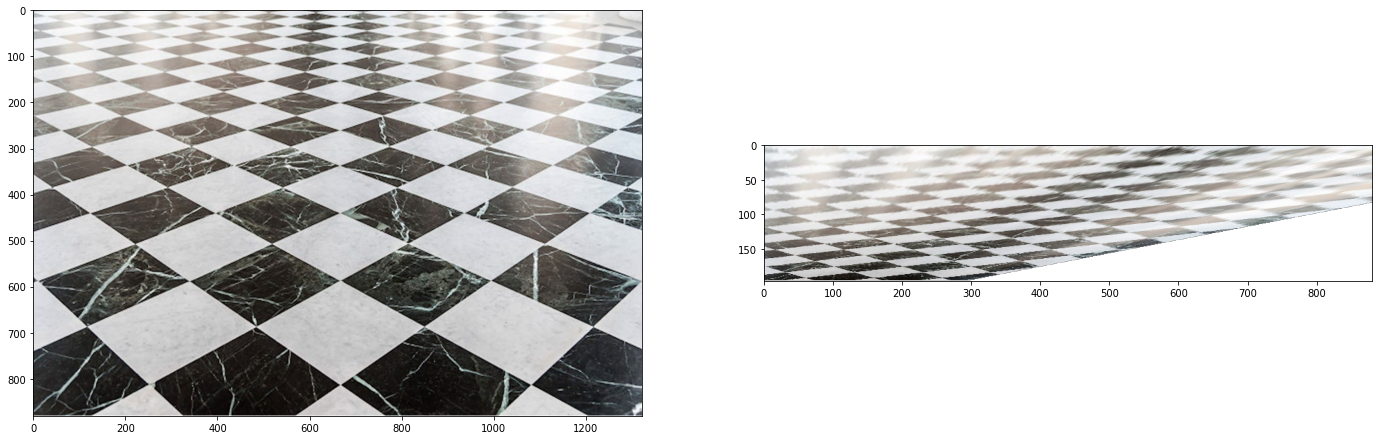

In [14]:
# Hp is used as hh for the algorithm
hh = Hp

# construct image
bounds, nrows, ncols,  trasf, trasf_prec = make_transform(img, hh)     
nn,mm  = img.shape[0],img.shape[0]
if max(nn,mm)>1000:
    kk =6
else: kk =5
nsamples = 10**kk
get_new_image(nrows, ncols, img, bounds, trasf_prec, nsamples)

To answer **point 4**, the resulting image in my opinion is not a true metric rectification. The resulting image seems to have removed the distortion caused by the projection as if we were looking from above, but it is a bit *\"flattened \"*. What would be missing is to apply a further affine transformation in order to make the image with the chessboard and the single squares of the original size and orientation, thus obtaining a true top-down image.